{'uci_id': 571, 'name': 'HCV data', 'repository_url': 'https://archive.ics.uci.edu/dataset/571/hcv+data', 'data_url': 'https://archive.ics.uci.edu/static/public/571/data.csv', 'abstract': 'The data set contains laboratory values of blood donors and Hepatitis C patients and demographic values like age.', 'area': 'Health and Medicine', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 615, 'num_features': 12, 'feature_types': ['Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['Category'], 'index_col': ['ID'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2020, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5D612', 'creators': ['Ralf Lichtinghagen', 'Frank Klawonn', 'Georg Hoffmann'], 'intro_paper': {'title': 'Using machine learning techniques to generate laboratory diagnostic pathways—a case study', 'authors': 'Georg F. Hoffmann, A. Bietenbeck, R. Lichtinghagen, F. Kla

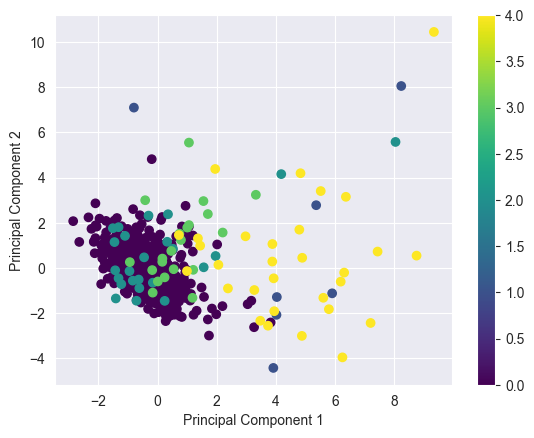

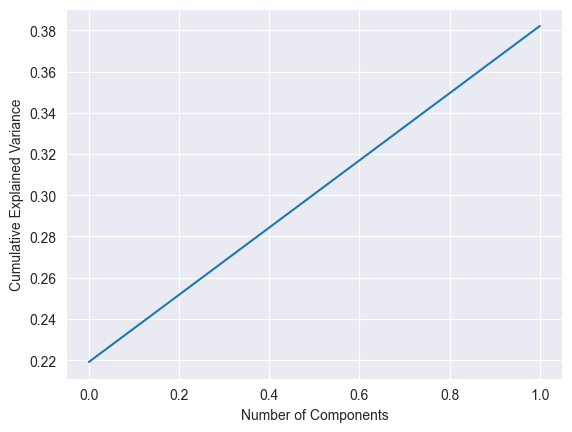

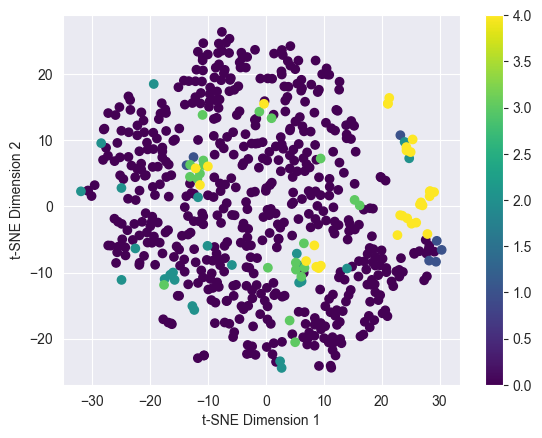

/Users/mwr/.conda/envs/A3_RACCA/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


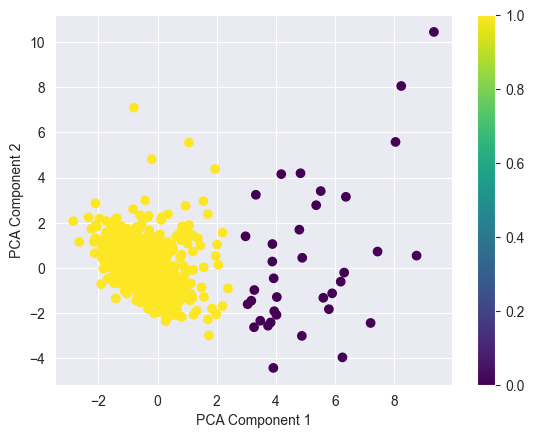

/Users/mwr/.conda/envs/A3_RACCA/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


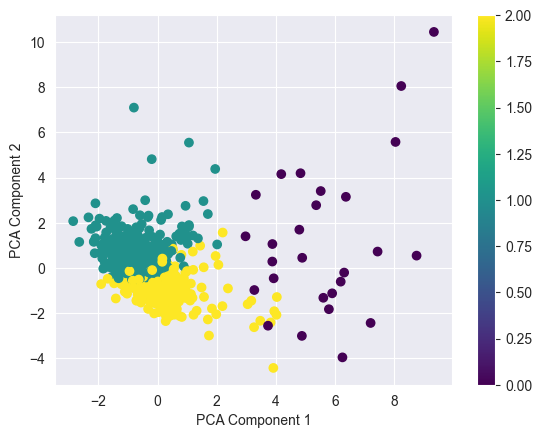

/Users/mwr/.conda/envs/A3_RACCA/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


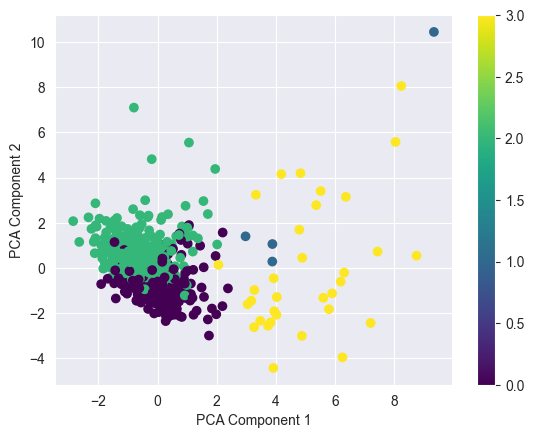

/Users/mwr/.conda/envs/A3_RACCA/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


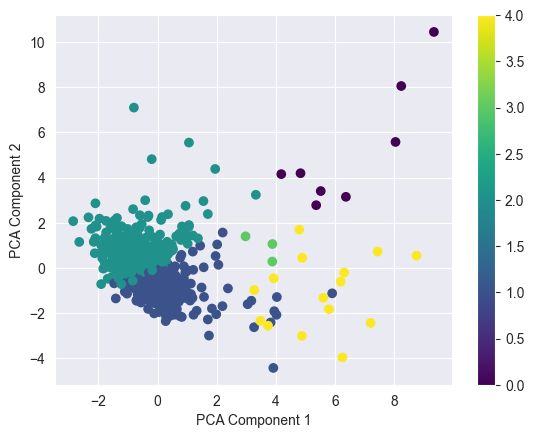

/Users/mwr/.conda/envs/A3_RACCA/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


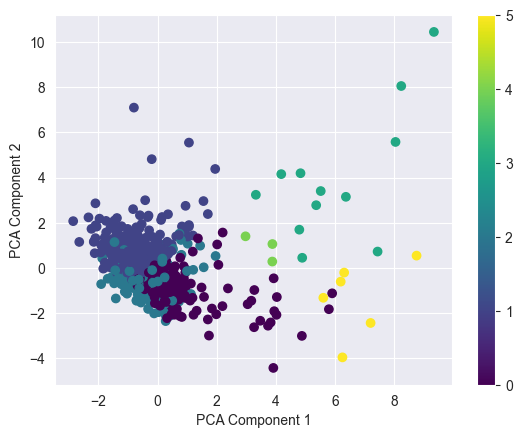

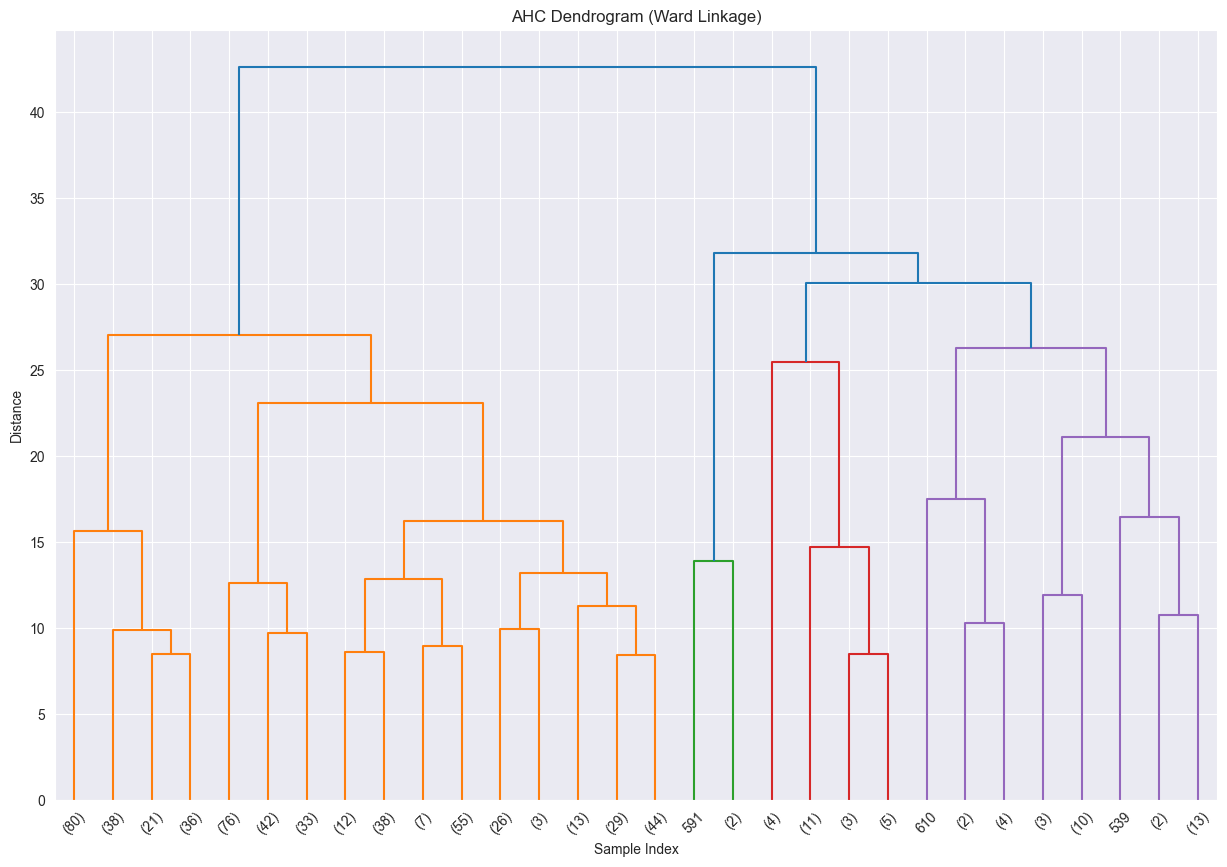

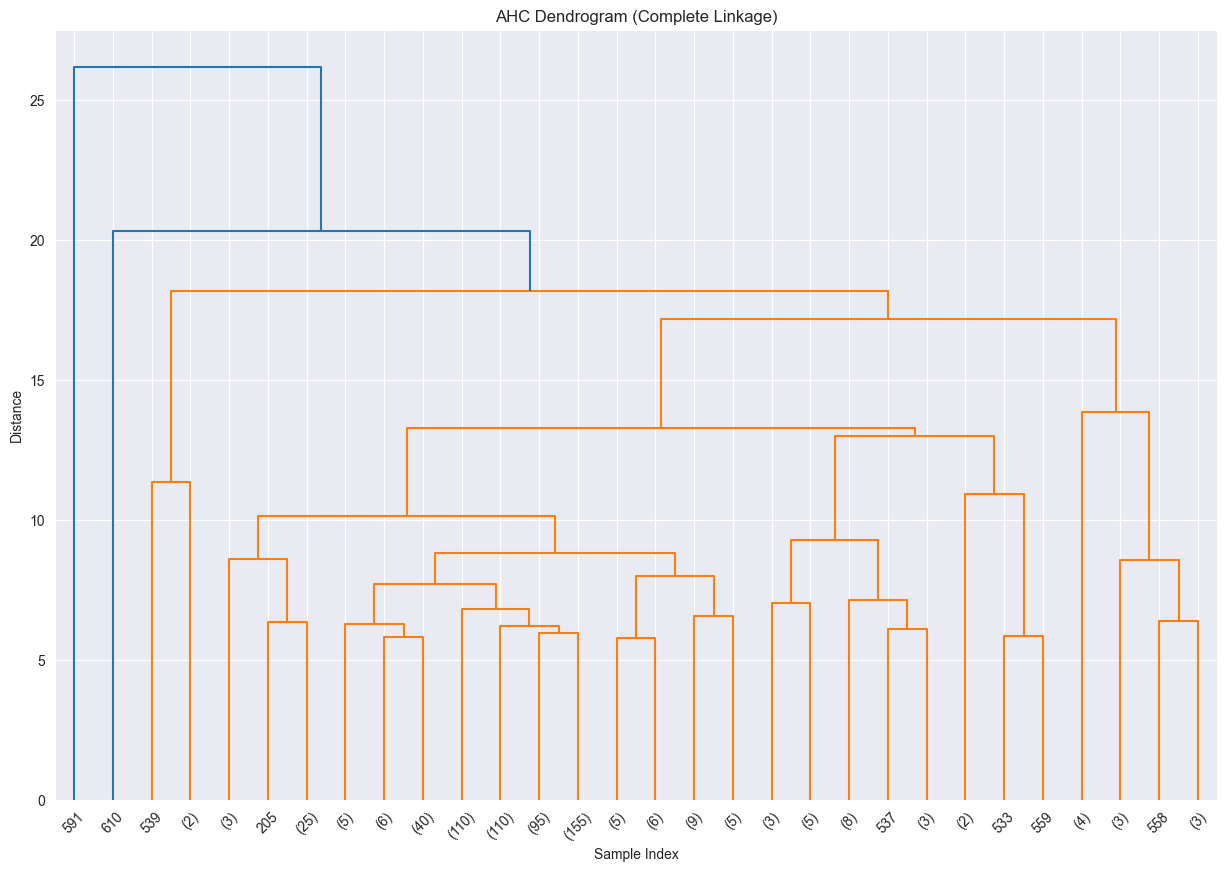

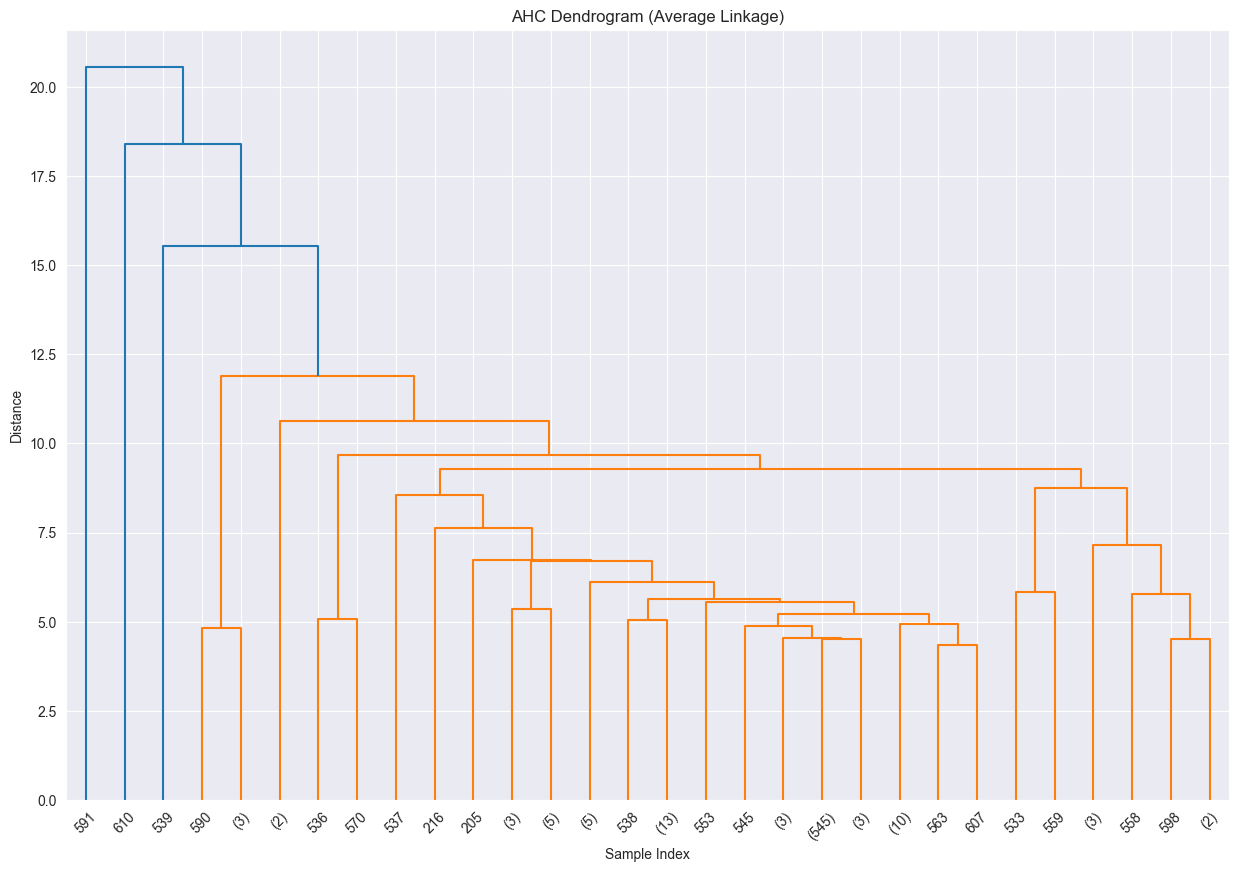

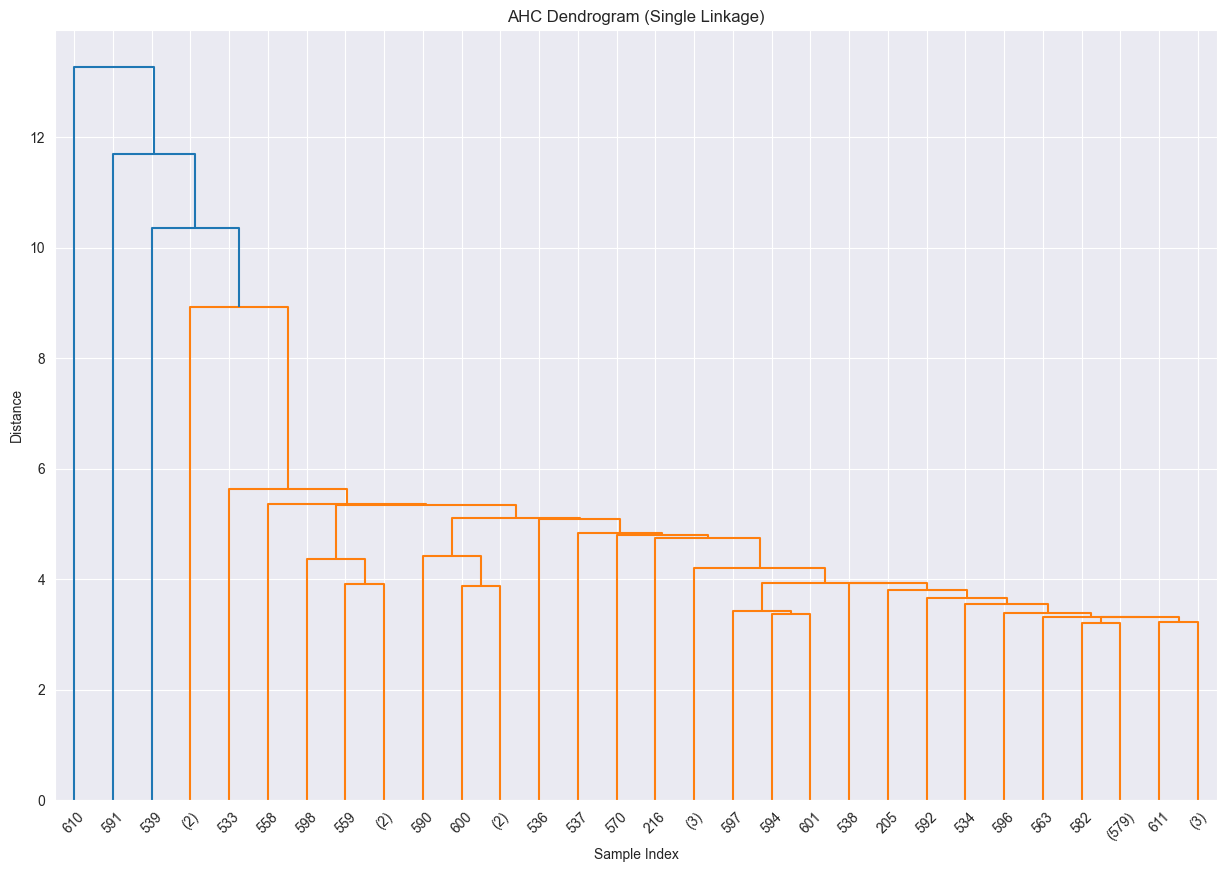

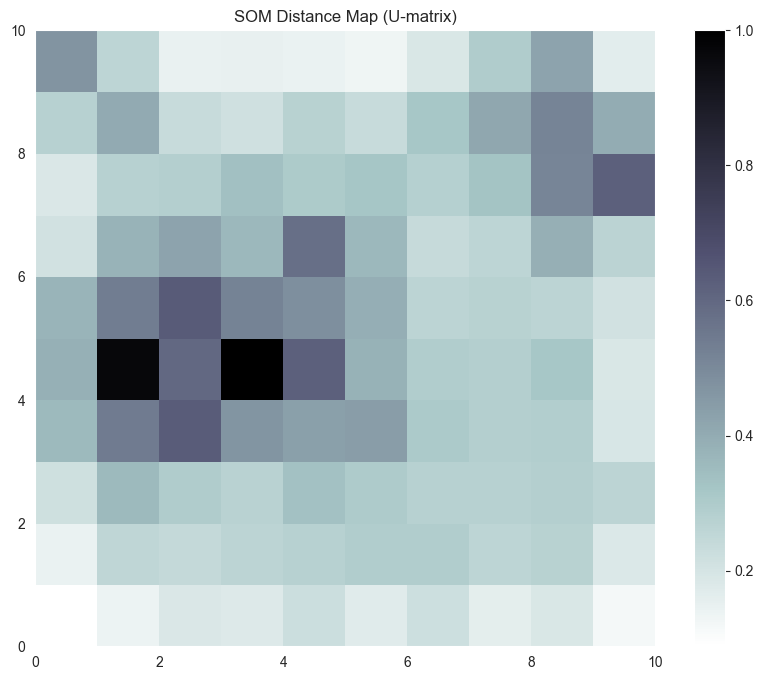

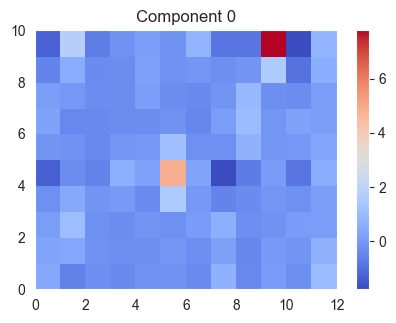

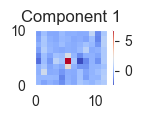

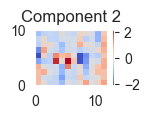

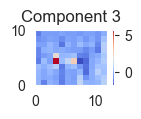

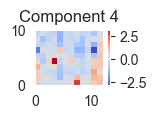

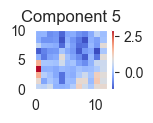

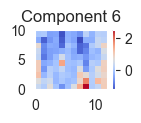

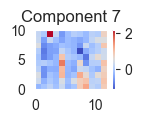

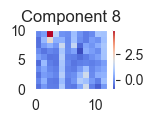

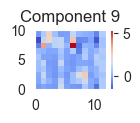

In [51]:

# Import necessary libraries
import requests
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline  
import matplotlib.pyplot as plt
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, silhouette_score
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from minisom import MiniSom

# Fetch dataset
hcv_data = fetch_ucirepo(id=571)

# Data (as pandas dataframes)
X = hcv_data.data.features 
y = hcv_data.data.targets

# Metadata
print(hcv_data.metadata)

# Variable information
print(hcv_data.variables)

# Identify categorical and numerical columns
categorical_cols = ['Sex']  # Replace with your actual categorical columns
numerical_cols = X.columns.difference(categorical_cols + ['ID'])  # Exclude 'ID' and categorical columns

# Define preprocessing pipelines
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='if_binary'))
])

# Combine preprocessing pipelines
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Preprocess the features
X_preprocessed = preprocessor.fit_transform(X)
X_preprocessed_df = pd.DataFrame(X_preprocessed, index=X.index,
    columns=(numerical_cols.tolist() + 
    preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols).tolist()))

# Save the preprocessed data
X_preprocessed_df.to_csv('preprocessed_hcv_data.csv', index=False)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_preprocessed_df)

# Convert y to a numpy array and encode labels
y_array = np.array(y).flatten() if isinstance(y, pd.DataFrame) else y
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_array)

# PCA Visualization
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

# PCA Scree Plot
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_preprocessed_df)

# t-SNE Visualization
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_encoded, cmap='viridis')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar()
plt.show()

# k-means Clustering
max_k = 6
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_preprocessed_df)
    
    # k-means Scatter Plot
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar()
    plt.show()

# AHC
for method in ['ward', 'complete', 'average', 'single']:
    linkage_matrix = linkage(X_preprocessed_df, method=method)
    
    # AHC Dendrogram
    plt.figure(figsize=(15, 10))
    dendrogram(linkage_matrix, truncate_mode='lastp', p=30)
    plt.title(f'AHC Dendrogram ({method.capitalize()} Linkage)')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.show()

# SOM
som = MiniSom(x=10, y=10, input_len=X_preprocessed_df.shape[1], sigma=1.0, learning_rate=0.5)
som.train_random(X_preprocessed_df.values, 1000)


# SOM U-matrix
plt.figure(figsize=(10, 8))
plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.colorbar()
plt.title('SOM Distance Map (U-matrix)')
plt.show()

# SOM Component Plan
plt.figure(figsize=(20, 15))
for i, comp in enumerate(som.get_weights()):
    plt.subplot(5, 5, i + 1)
    plt.title(f'Component {i}')
    plt.pcolor(comp, cmap='coolwarm')
    plt.colorbar()
    plt.tight_layout()
    plt.show()